# 0.0 IMPORTS

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from IPython.display import Image
import matplotlib.gridspec as gridspec
from IPython.core.display import HTML
from scipy import stats as ss


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 14]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

    
#Cramer's V

def cramer(x,y):
    cm = pd.crosstab(x,y).values
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    n = cm.sum()
    
    r,k = cm.shape
    
    v = np.sqrt((chi2/n) / (min(k-1,r-1)))
    
    phi2 = chi2/n
    
    phi2corr = max(0,(phi2 - ((k-1)*(r-1))/(n-1)))
    
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt(phi2corr/(min(kcorr-1,rcorr-1)))


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_raw_sale = pd.read_csv('data/train.csv', low_memory = False)
df_raw_store = pd.read_csv('data/store.csv',low_memory = False)

In [5]:
df_raw = pd.merge(df_raw_sale,df_raw_store, how='left',on='Store')

# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
               'Assortment',     'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
               'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snake_case = lambda x : inflection.underscore(x)

new_columns = list(map(snake_case,old_columns))

#Rename Columns
df1.columns = new_columns


## 1.2 Data Dimensions

In [9]:
df1.shape

(1017209, 18)

In [10]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
#date to datetime

df1['date'] =pd.to_datetime(df1['date'])

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA


In [15]:
df1['competition_distance'].max()

75860.0

In [16]:
#competition_distance   
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month    

df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
                       
#promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval                  
df1['promo_interval'].fillna(0,inplace=True)
    
    #aproveitando essa informacao para saber se esses meses com promoção2 influenciaram no aumento das vendas

dic_month = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
df1['month_of_date'] = df1['date'].dt.month.map(dic_month)

df1['is_promo2'] = df1[['promo_interval','month_of_date']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_of_date'] in x['promo_interval'].split(',') else 0, axis =1)

## 1.6 Change Types

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [19]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo2'],
      dtype='object')

In [20]:
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

In [21]:
cat_attributes.columns

Index(['date', 'state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_of_date'],
      dtype='object')

### 1.7.1 Numerical Attributes

In [22]:
#Métricas de Tendência Central

tc1 = pd.DataFrame(num_attributes.mean())
tc2 = pd.DataFrame(num_attributes.median())

#Métricas de Dispersão

dp1 = pd.DataFrame(num_attributes.std())
dp2 = pd.DataFrame(num_attributes.min())
dp3 = pd.DataFrame(num_attributes.max())
dp4 = pd.DataFrame(num_attributes.skew())
dp5 = pd.DataFrame(num_attributes.kurtosis())
dp6 = pd.DataFrame(num_attributes.apply(lambda x: x.max()- x.min()))



In [23]:
#Unindo as métricas
m = pd.concat([tc1,tc2,dp2,dp3,dp6,dp1,dp4,dp5],axis=1,sort='True').reset_index()
m.columns = ['attributes','media','media','min','max','range','std','skew','kurtosis']

In [24]:
m

,attributes,media,media,min,max,range,std,skew,kurtosis
0,competition_distance,5935.442677,2330.0,20.0,200000.0,199980.0,12547.652996,10.242344,147.789712
1,competition_open_since_month,6.786849,7.0,1.0,12.0,11.0,3.311087,-0.042076,-1.232607
2,competition_open_since_year,2010.324840,2012.0,1900.0,2015.0,115.0,5.515593,-7.235657,124.071304
3,customers,633.145946,609.0,0.0,7388.0,7388.0,464.411734,1.598650,7.091773
4,day_of_week,3.998341,4.0,1.0,7.0,6.0,1.997391,0.001593,-1.246873
5,is_promo2,0.171835,0.0,0.0,1.0,1.0,0.377237,1.739838,1.027039
6,open,0.830107,1.0,0.0,1.0,1.0,0.375539,-1.758045,1.090723
7,promo,0.381515,0.0,0.0,1.0,1.0,0.485759,0.487838,-1.762018
8,promo2,0.500564,1.0,0.0,1.0,1.0,0.500000,-0.002255,-1.999999
9,promo2_since_week,23.619033,22.0,1.0,52.0,51.0,14.310064,0.178723,-1.184046


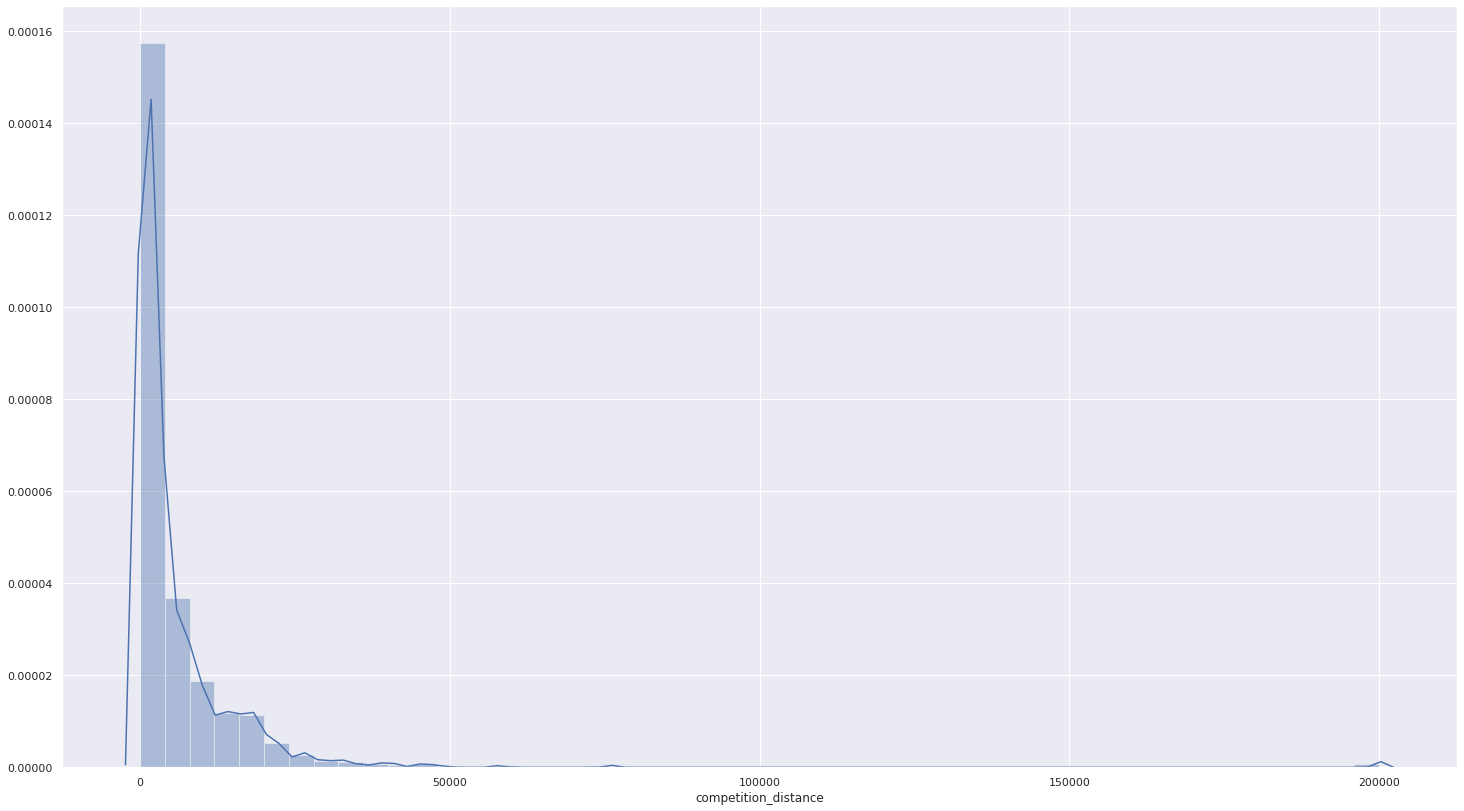

In [25]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

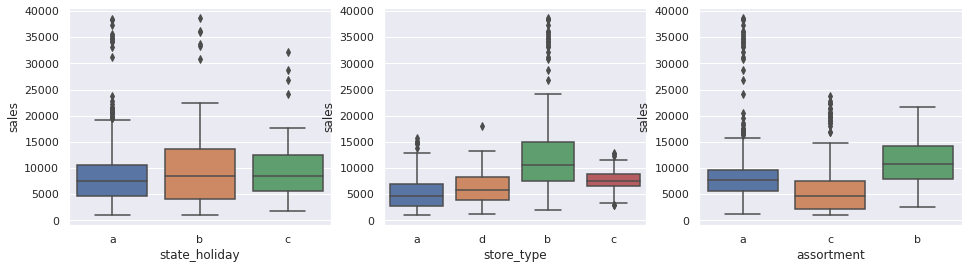

In [26]:
plt.figure(figsize=(16,4))
aux_plot = df1.loc[(df1['state_holiday']!='0') & (df1['sales']>0) ]


#filter in state_holiday to plot

plt.subplot(1,3,1)
sns.boxplot( x = "state_holiday", y ="sales",data = aux_plot)


#filter in store_type to plot
plt.subplot(1,3,2)
sns.boxplot( x = "store_type", y ="sales",data = aux_plot)


#filter in assortment to plot
plt.subplot(1,3,3)
sns.boxplot( x = "assortment", y ="sales",data = aux_plot)




In [27]:
df1.loc[df1['competition_distance']==200000].sample(5).T

,738750,522771,30983,829065,347881
store,291,622,879,291,291
day_of_week,6,4,6,2,3
date,2013-09-07 00:00:00,2014-03-20 00:00:00,2015-07-04 00:00:00,2013-06-18 00:00:00,2014-09-03 00:00:00
sales,4524,3666,3493,8960,8418
customers,491,404,330,908,873
open,1,1,1,1,1
promo,0,1,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,d,d,d


# 2.0 PASSO 02 - FEATURE ENGINEERING

In [28]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

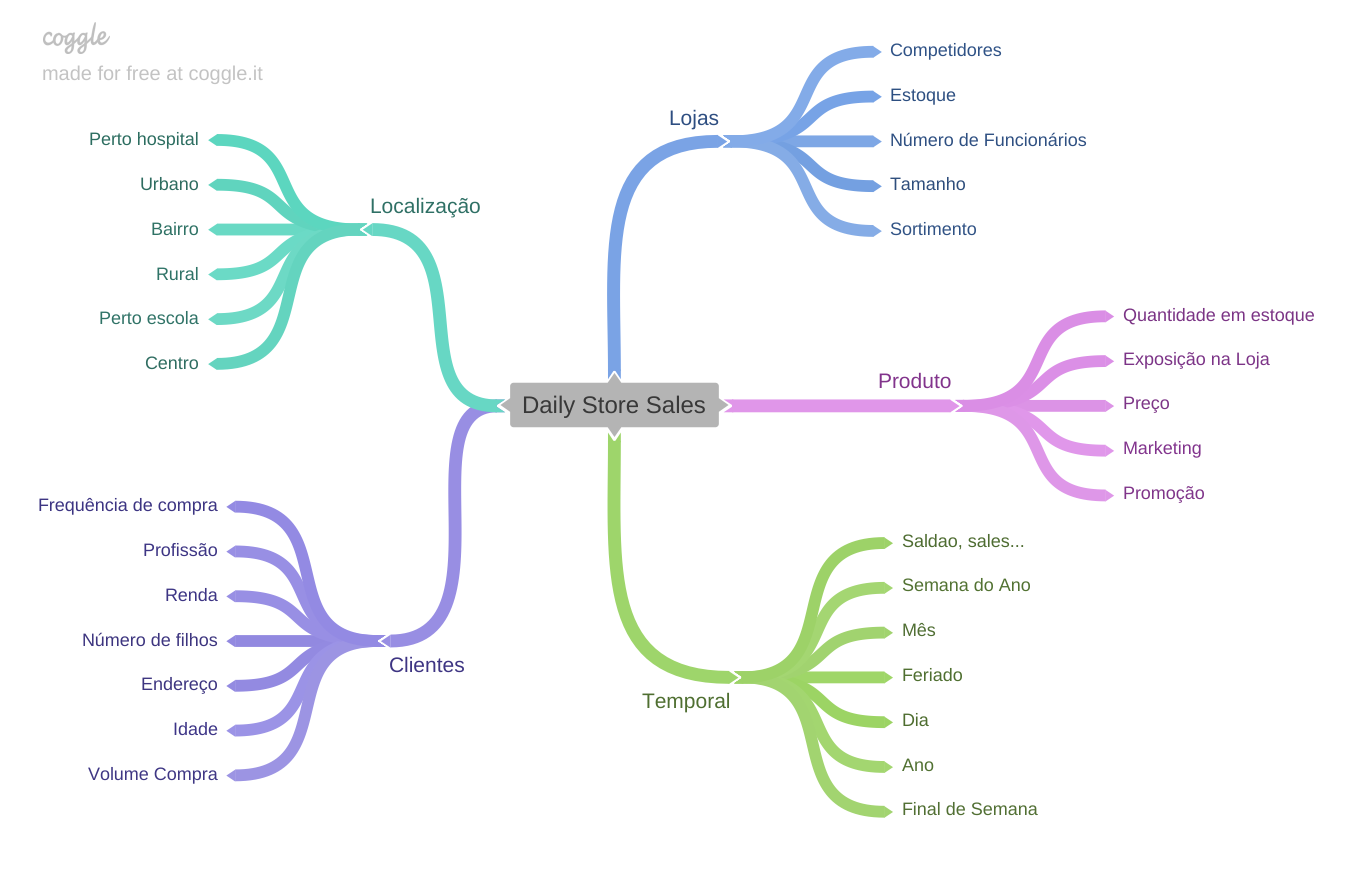

In [29]:
Image(filename='img/mm_hip.png') 

## 2.2 Criação das Hipóteses

**2.2.1.** Hipóteses Lojas

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

**2.2.2.** Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**2.2.3.** Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Lista final de Hipóteses

**1.**   Lojas com maior sortimentos deveriam vender mais.
  
**2.**   Lojas com competidores mais próximos deveriam vender menos.
  
**3.**   Lojas com competidores à mais tempo deveriam vendem mais.
  
**4.**   Lojas com promoções ativas por mais tempo deveriam vender mais
  
**5.**   Lojas com mais dias de promoção deveriam vender mais.
  
**6.**   Lojas com mais promoções consecutivas deveriam vender mais.
  
**7.**   Lojas abertas durante o feriado de Natal deveriam vender mais.
  
**8.**   Lojas deveriam vender mais ao longo dos anos.
  
**9.**   Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [30]:
#year
df2['year']=df2['date'].dt.year

#month
df2['month']=df2['date'].dt.month

#week
df2['day']=df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].apply(lambda x: x.strftime('%Y-%W'))

#competition since (unidade: mês)
df2['competition_since'] = df2['competition_open_since_year'].astype(str) + '-'+ df2['competition_open_since_month'].astype(str)+'-1'
df2['competition_since'] = df2['competition_since'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d') )
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

##promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)+'-1'
df2['promo_since'] = (df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%W-%w'))) - datetime.timedelta(days=7)
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

#state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x=='a' else 
                                                  'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [31]:
df3 = df2.copy()

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_of_date', 'is_promo2',
       'year', 'month', 'day', 'week_of_year', 'year_week',
       'competition_since', 'competition_time_month', 'promo_since',
       'promo_time_week'],
      dtype='object')

## 3.1 Filtragem de linhas

In [33]:
df3 = df3[(df3['sales']>0) & (df3['open']!=0)]


In [34]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_of_date', 'is_promo2',
       'year', 'month', 'day', 'week_of_year', 'year_week',
       'competition_since', 'competition_time_month', 'promo_since',
       'promo_time_week'],
      dtype='object')

## 3.1 Seleção de colunas

In [35]:
cols_drop = ['customers','open','month_of_date','promo_interval']
df3 = df3.drop(cols_drop,axis=1)

In [36]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo2', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS

In [37]:
df4 = df3.copy()

In [38]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Análise Univariada

### Response Variable

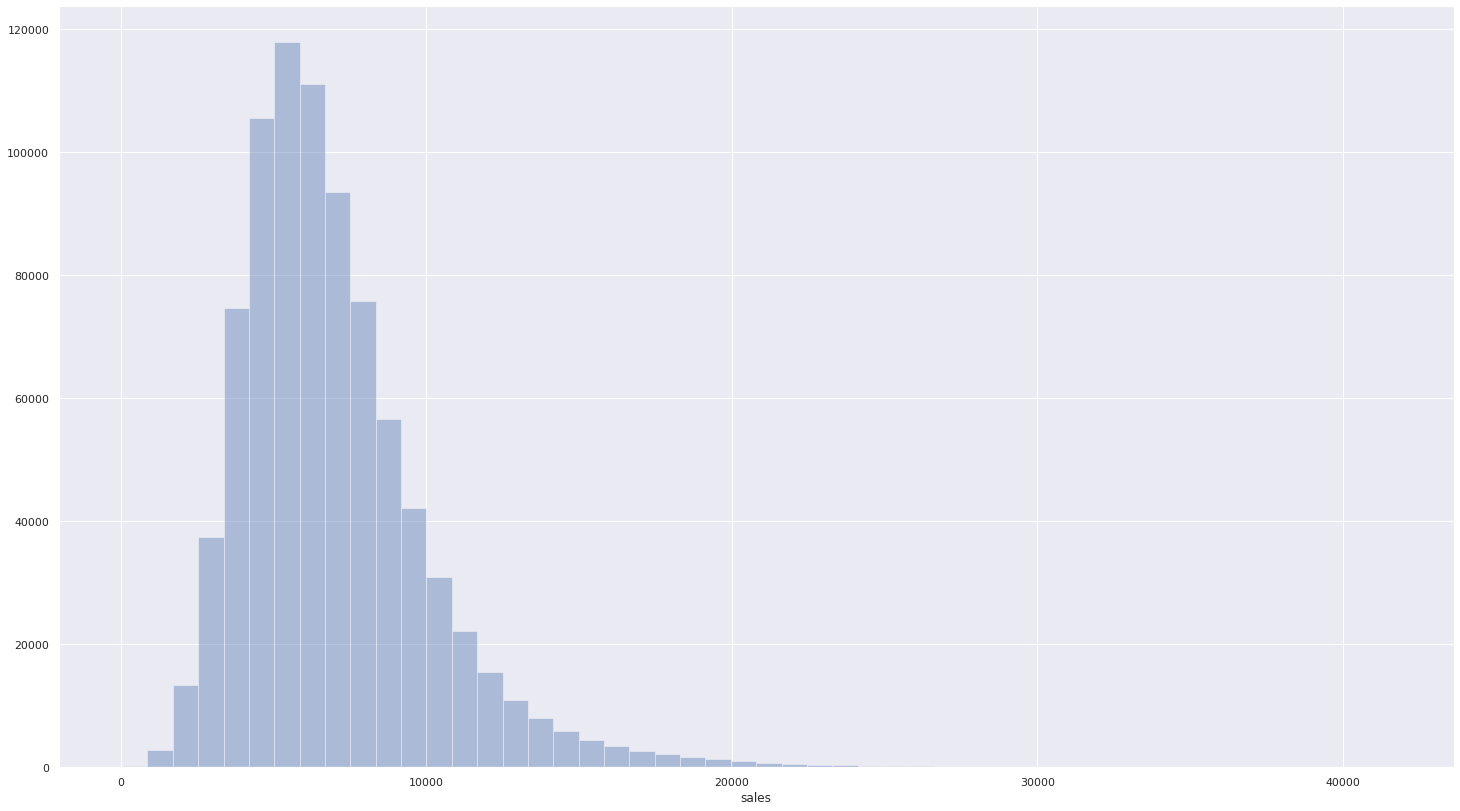

In [39]:
sns.distplot(df4['sales'], kde = False);

### Numerical Attributes

In [40]:
num_attributes = df4.select_dtypes(include=['int64','float64'])

In [41]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'promo', 'school_holiday',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo2', 'year', 'month', 'day',
       'week_of_year', 'competition_time_month', 'promo_time_week'],
      dtype='object')

In [42]:
num_attributes.shape

(844338, 18)

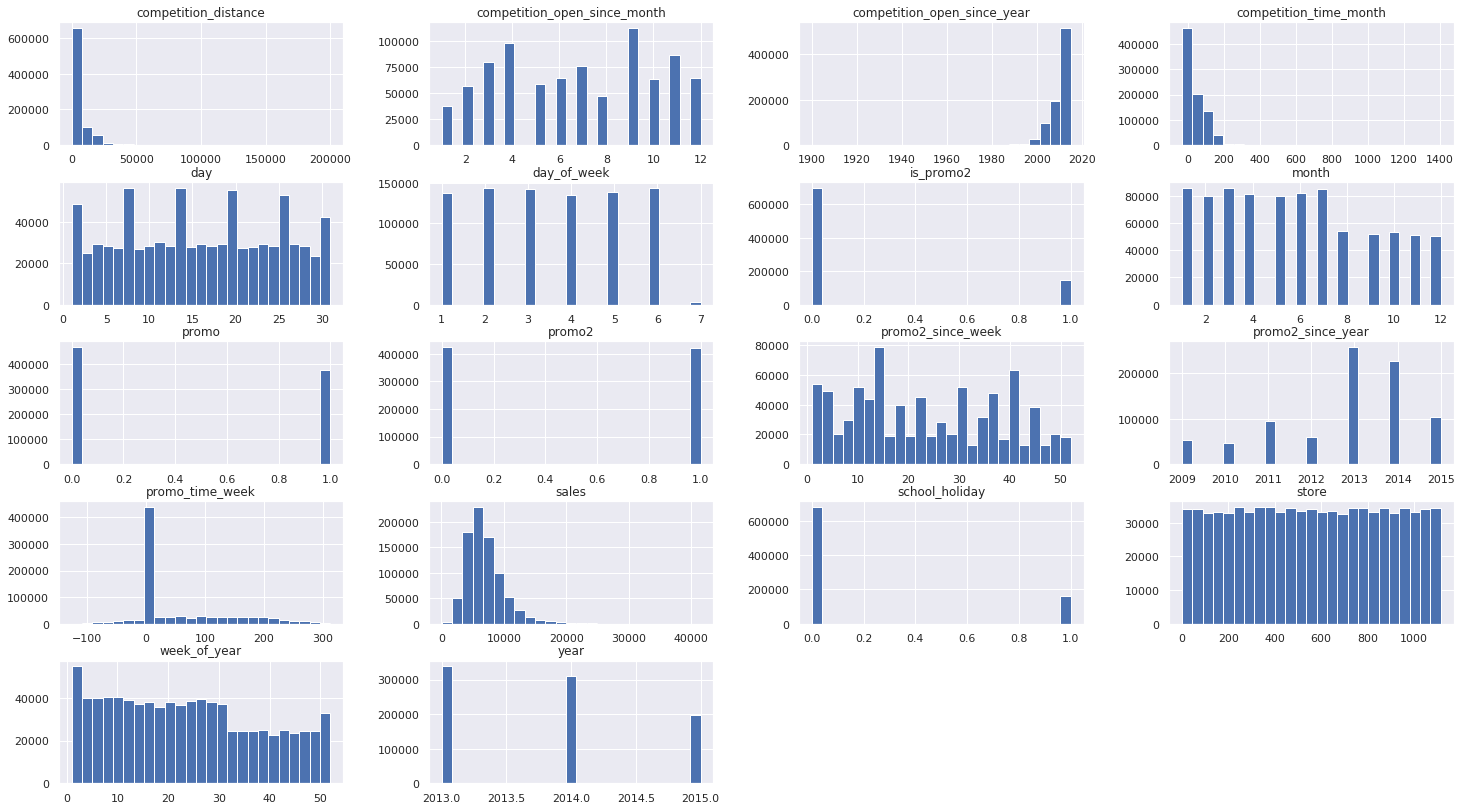

In [43]:
num_attributes.hist(bins=25);

### Categorical Attributes

In [44]:
cat_attributes = df4.select_dtypes(include = 'object')

In [45]:
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

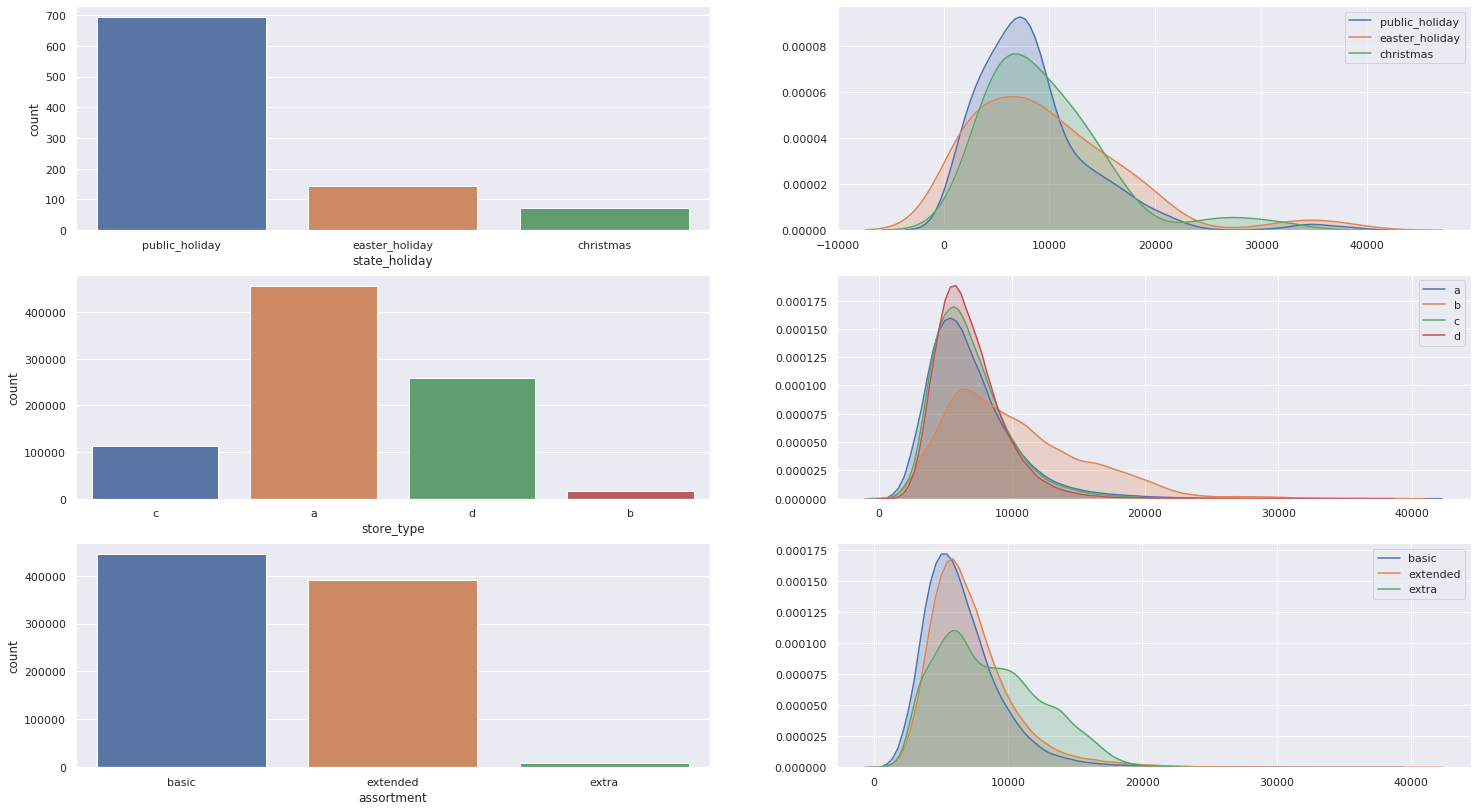

In [46]:
#STATE HOLIDAY
plt.subplot(3,2,1)
aux1 = df4[df4['state_holiday']!='regular_day']
sns.countplot(x='state_holiday',data=aux1)
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday',shade='True')
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',shade='True')
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas',shade='True')

#STORE TYPE
plt.subplot(3,2,3)
sns.countplot(x='store_type',data=df4)
plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a',shade='True')
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b',shade='True')
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c',shade='True')
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d',shade='True')

#ASSORTMENT
plt.subplot(3,2,5)
sns.countplot(x='assortment',data=df4)
plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label='basic',shade='True')
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label='extended',shade='True')
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label='extra',shade='True')


## Análise Bivariada

### H1.Lojas com maior sortimentos deveriam vender mais.
**Verdadeiro. Lojas com classificadas com sortimento extra, em média, vendem mais.**
  

In [47]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

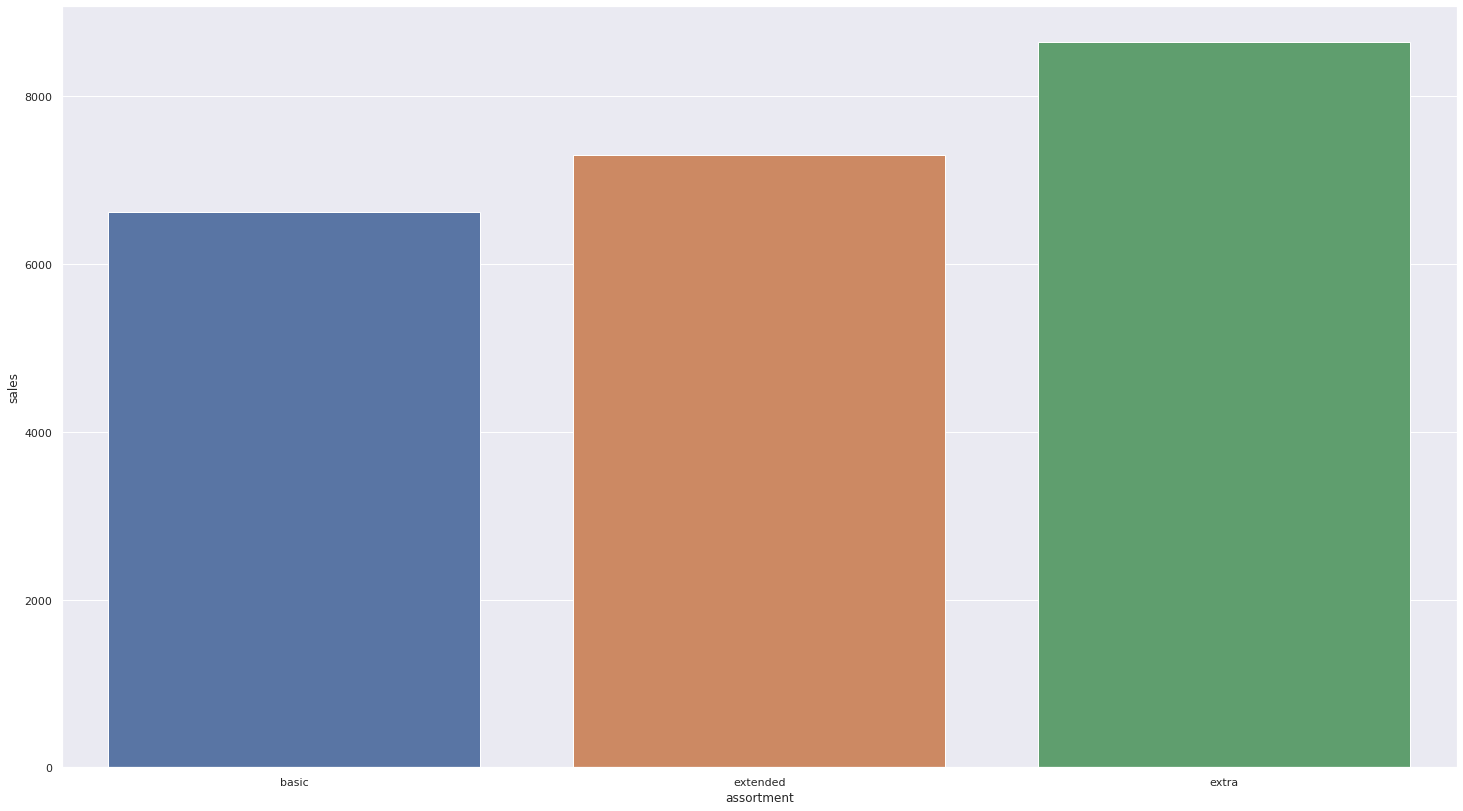

In [48]:
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1)

In [49]:
aux_2.sample(5)

NameError: name 'aux_2' is not defined

In [ ]:
aux_2 = df4[['assortment','year_week','sales']].groupby(['assortment','year_week']).mean().reset_index()
aux_2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
 **Falsa. Obersava-se que lojas com competidores mais próximos vendem mais.**

In [ ]:
aux_1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
bins = list(np.arange(0,20000,1000))
aux_1['inter_competition_distance'] = pd.cut(aux_1['competition_distance'], bins=bins)
aux_2 = aux_1[['inter_competition_distance','sales']].groupby('inter_competition_distance').sum().reset_index()

In [ ]:
df4['competition_distance'].quantile([0.25,0.5,0.75])

In [ ]:
plt.subplot(1,3,1)
sns.barplot(x='competition_distance',y='sales',data=aux_1)

plt.subplot(1,3,2)
sns.barplot(x='inter_competition_distance',y='sales',data=aux_2)

plt.subplot(1,3,3)
sns.heatmap(aux_1.corr( method='pearson' ),annot=True)

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
 **Falsa. Lojas com competidores a mais tempo apresentam menos vendas.**

In [ ]:
#Competition_time_month = 0 representa as lojas que não tem competidores próximos naquela data da venda
aux = df4[df4['competition_time_month']!=0]
aux_1 = aux[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

In [ ]:
aux_2 = df4[(df4['competition_time_month']<120) & (df4['competition_time_month']!=0)]
aux_3 = aux_2[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

In [ ]:
#Plots

plt.subplot(1,3,1)
sns.regplot(x='competition_time_month',y='sales',data=aux_1)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux_3)

plt.subplot(1,3,3)
sns.heatmap(aux_1.corr(method='pearson'),annot=True)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
  

In [ ]:
#Considerando apenas a partir do momento em que a promoção já está ativa

aux = df4[df4['promo_time_week']>0]
aux_1 = aux[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()


#Considerando apenas quando a promoção não está ativa

aux_2 = df4[df4['promo_time_week']<0]
aux_3 = aux_2[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()


In [ ]:
#Plot

spec = GridSpec(2,3)

plt.subplot(spec[0,0])
sns.barplot(x='promo_time_week',y='sales',data=aux_1)

plt.subplot(spec[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux_1)

plt.subplot(spec[0,2])
sns.heatmap(aux_1.corr(method='pearson'),annot=True)

plt.subplot(spec[1,0])
sns.barplot(x='promo_time_week',y='sales',data=aux_3)

plt.subplot(spec[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux_3)

plt.subplot(spec[1,2])
sns.heatmap(aux_3.corr(method='pearson'),annot=True)

### H4.1. Lojas quando estão em promoção extendida vendem mais.
**Não. Lojas quando estão nos meses da promoção extendida, não vendem mais.**

In [ ]:
#Em promoção extendida
aux = df4[df4['is_promo2']==1]
aux_1 = aux['sales'].mean()
aux_1

In [ ]:
#Sem estar em momento promoção extendida
aux_2 = df4[df4['is_promo2']==0]
aux_3 = aux_2['sales'].mean()
aux_3

### H5. Lojas com mais dias de promoção deveriam vender mais.
**Falsa. Lojas que participam apenas das promoções regulares, em média, vendem mais.**

In [ ]:
#Lojas com mais dias de promoção são aquelas que fazem parte das promoções normais e das promoções consecutivas e nos dias analisados está em promo2, assim:
aux = df4[(df4['promo']==1) & (df4['is_promo2']==1)]
sales_mean_1 = aux['sales'].mean()
sales_mean_1


In [ ]:
#Lojas com menos dias de promoção são aquelas que não fazem parte das promoções consecutivas, assim:
aux_1 = df4[(df4['promo']==1) & (df4['promo2']==0)]
sales_mean_2 = aux_1['sales'].mean()
sales_mean_2

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa. Lojas que não participam do período de promoção consecutiva, em média, vende menos.**

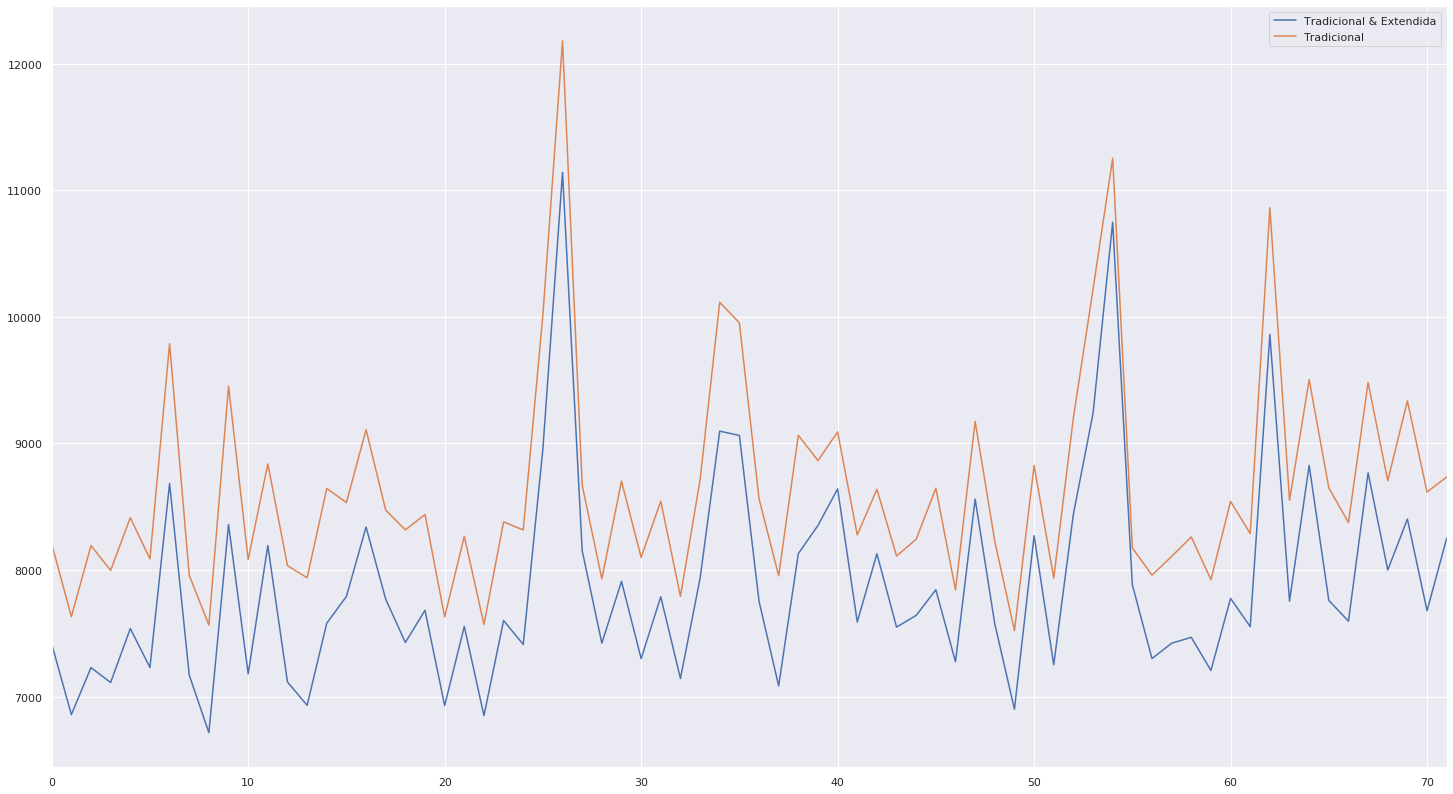

In [50]:
#Lojas com mais promoções consecutivas são aquelas que participam da promo1 e da promo2 (lembrando que promo2=1 significa apenas que a loja participa dessa promoção, mas não necessariamente que no dia da venda ela está participando)


aux_1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').mean().reset_index()
ax = aux_1.plot()

#Lojas com menos promoções consecutivas são aquelas que participam apenas da promo1
aux_2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux_2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
 **Falsa. O feriado de Natal vende menos que os outros dias de feriado.**

In [ ]:
df4.head()

aux=df4[df4['state_holiday']!='regular_day']

aux_1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday',y='sales',data=aux_1)

#Analisando ao longo dos anos

plt.subplot(1,2,2)
aux_2 = aux[['state_holiday','sales','year']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux_2)

### H8. Lojas deveriam vender mais ao longo dos anos.
**Falsa. As vendas estão caindo ao longo dos anos.**
  

In [ ]:
aux = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'),annot=True)


### H9. Lojas deveriam vender mais no segundo semestre do ano.
 **Falsa. As lojas vendem mais no primeiro semestre do ano.**

In [ ]:
aux = df4[['month','sales']].groupby('month').sum().reset_index()

spec = GridSpec(1,3)

subplot(spec[0,0])
sns.barplot(x='month',y='sales',data=aux)

subplot(spec[0,1])
sns.regplot(x='month',y='sales',data=aux)

subplot(spec[0,2])
sns.heatmap(aux.corr(method='pearson'),annot=True)


### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
 **Verdadeiro. As lojas vendem mais depois do dia 10 de cada mês**

In [ ]:
aux = df4[['day','sales']].groupby('day').sum().reset_index()

spec = GridSpec(1,3)

subplot(spec[0,0])
sns.barplot(x='day',y='sales',data=aux)

subplot(spec[0,1])
sns.regplot(x='day',y='sales',data=aux)

subplot(spec[0,2])
sns.heatmap(aux.corr(method='pearson'),annot=True)

### H11. Lojas deveriam vender menos aos finais de semana.
**Verdadeiro. Lojas vendem menos durantes os finais de semana.**

In [ ]:
aux = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'),annot=True)


### H12. Lojas deveriam vender menos durante os feriados escolares.

**Verdadeiro. Lojas vendem menos durante os feriados escolares, exceto durante o mês de agosto, que é um mês de férias e certamente por isso as vendas são maiores.**

In [ ]:
aux = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='school_holiday',y='sales',data=aux)

#Por mês

plt.subplot(1,2,2)
aux_1 = df4[['school_holiday','month','sales']].groupby(['school_holiday','month']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux_1)

## Análise Multivariada

### Numerical Attributes

In [ ]:
num_attributes = df4.select_dtypes(include=['int64','float64'])

In [ ]:
sns.heatmap(num_attributes.corr(method='pearson'),annot=True)

### Categorical Attributes

In [75]:
cat_attributes = df4.select_dtypes(include='object')
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

In [76]:
a1 = cramer(cat_attributes['state_holiday'],cat_attributes['state_holiday'])
a2 = cramer(cat_attributes['state_holiday'],cat_attributes['assortment'])
a3 = cramer(cat_attributes['state_holiday'],cat_attributes['store_type'])

a4 = cramer(cat_attributes['store_type'],cat_attributes['store_type'])
a5 = cramer(cat_attributes['store_type'],cat_attributes['assortment'])
a6 = cramer(cat_attributes['store_type'],cat_attributes['state_holiday'])

a7 = cramer(cat_attributes['assortment'],cat_attributes['assortment'])
a8 = cramer(cat_attributes['assortment'],cat_attributes['store_type'])
a9 = cramer(cat_attributes['assortment'],cat_attributes['state_holiday'])



In [77]:
cramer_tab = pd.DataFrame({'state_holiday':[a1, a3, a2],
              'store_type':[a6,a4,a5],
              'assortment':[a9,a8,a7]
             })

In [78]:
cramer_tab = cramer_tab.set_index(cramer_tab.columns)

In [79]:
cramer_tab

,state_holiday,store_type,assortment
state_holiday,1.000000,0.071040,0.067519
store_type,0.071040,1.000000,0.538454
assortment,0.067519,0.538454,1.000000


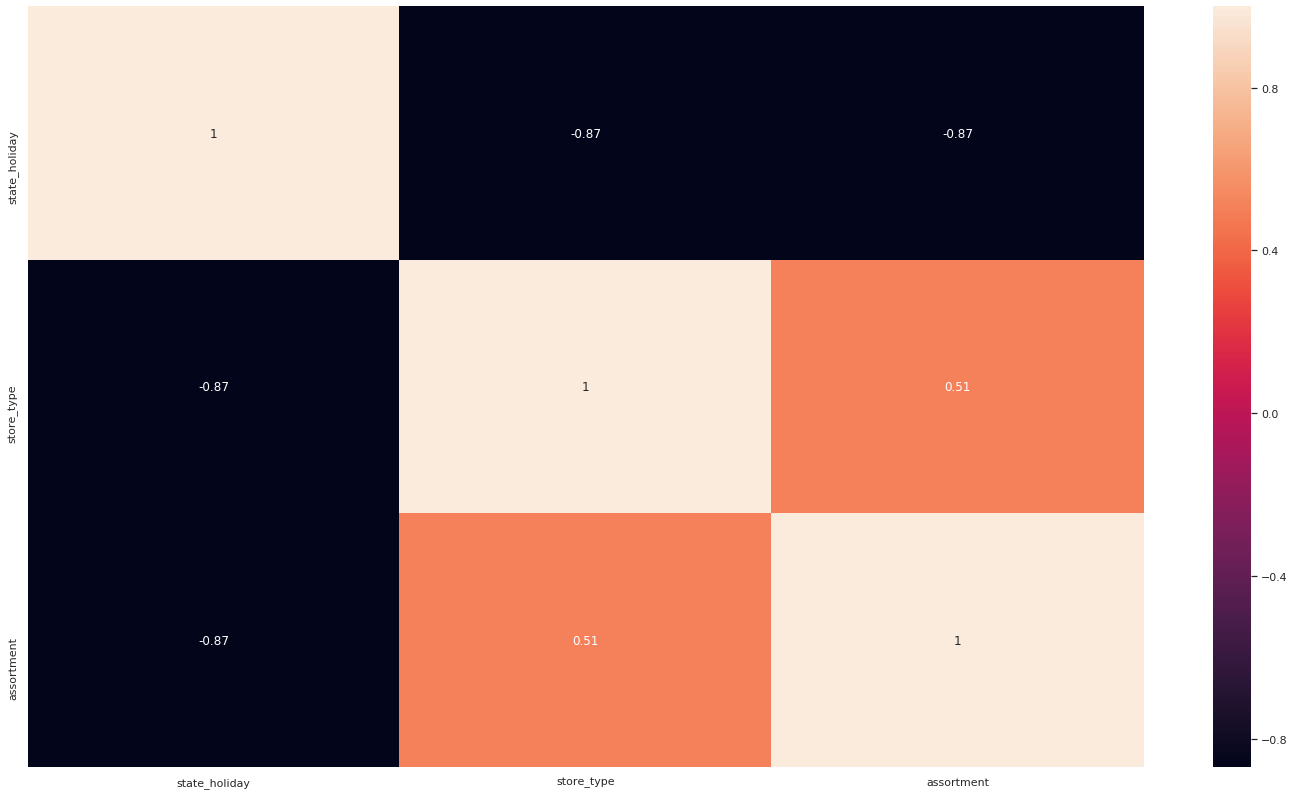

In [80]:
sns.heatmap(cramer_tab.corr(method='pearson'),annot=True)